In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [2]:
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)


In [3]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

# ディープニューラルネットワークスクラッチ

## 【問題1】全結合層のクラス化
全結合層のクラス化を行なってください。

以下に雛形を載せました。コンストラクタで重みやバイアスの初期化をして、あとはフォワードとバックワードのメソッドを用意します。重みW、バイアスB、およびフォワード時の入力Xをインスタンス変数として保持しておくことで、煩雑な入出力は不要になります。

なお、インスタンスも引数として渡すことができます。そのため、初期化方法のインスタンスinitializerをコンストラクタで受け取れば、それにより初期化が行われます。渡すインスタンスを変えれば、初期化方法が変えられます。

また、引数として自身のインスタンスselfを渡すこともできます。これを利用してself.optimizer.update(self)という風に層の重みの更新が可能です。更新に必要な値は複数ありますが、全て全結合層が持つインスタンス変数にすることができます。

初期化方法と最適化手法のクラスについては後述します。

In [4]:
class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        # ノードの最適化・初期化インスタンス
        self.optimizer = optimizer
        self.initializer = initializer

        # ノード内の重みとバイアスを初期化
        self.W = self.initializer.W(n_nodes1, n_nodes2)
        self.B = self.initializer.B(n_nodes2, )
        
    def forward(self, X):
        self.X_prev = X
        A = X @ self.W + self.B
        return A

    def backward(self, dA):
        # 勾配計算
        self.dB = np.sum(dA, axis=0)
        self.dW = self.X_prev.T @ dA
        
        # 重み・バイアスの更新
        self.optimizer.update(self)
        dZ = dA @ self.W.T
        
        return dZ

## 【問題2】初期化方法のクラス化
初期化を行うコードをクラス化してください。

前述のように、全結合層のコンストラクタに初期化方法のインスタンスを渡せるようにします。
以下の雛形に必要なコードを書き加えていってください。
標準偏差の値（sigma）はコンストラクタで受け取るようにすることで、全結合層のクラス内にこの値（sigma）を渡さなくてすむようになります。

これまで扱ってきた初期化方法はSimpleInitializerクラスと名付けることにします。

In [5]:
class SimpleInitializer:
    def __init__(self, sigma):
        self.sigma = sigma
        
    def W(self, n_nodes1, n_nodes2):
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W
    
    def B(self, n_nodes2):
        B = self.sigma * np.random.randn(n_nodes2, )
        return B

## 【問題3】最適化手法のクラス化
最適化手法のクラス化を行なってください。

最適化手法に関しても初期化方法同様に全結合層にインスタンスとして渡します。

バックワードのときにself.optimizer.update(self)のように更新できるようにします。

以下の雛形に必要なコードを書き加えていってください。

これまで扱ってきた最適化手法はSGDクラス（Stochastic Gradient Descent、確率的勾配降下法）として作成します。

In [6]:
class SGD:
    def __init__(self, lr):
        self.lr = lr
    def update(self, layer):
        layer.B -= self.lr * layer.dB
        layer.W -= self.lr * layer.dW


## 【問題4】活性化関数のクラス化
活性化関数のクラス化を行なってください。

ソフトマックス関数のバックプロパゲーションには交差エントロピー誤差の計算も含む実装を行うことで計算が簡略化されます。

In [7]:
class Sigmoid:
    """
    Sigmoid関数のクラス
    """  
    def __init__(self):
        pass
    
    def forward(self, X):
        self.A = X
        return 1 / (1 + np.exp(-X))
    
    def backward(self, X):
        return X * (1- self.forward(self.A)) * self.forward(self.A)

In [8]:
class Tanh:
    """
    Tanh関数のクラス
    """
    def __init__(self):
        pass
    
    def forward(self, X):
        self.A = X
        return np.tanh(X)
    
    def backward(self, X):
        return X * (1 - self.forward(self.A)**2)

In [9]:
class Softmax:
    def __init__(self):
        pass
    
    def forward(self, X):
        X = X - np.max(X)
        return np.exp(X) / np.sum(np.exp(X), axis=1, keepdims=True)
    
    def backward(self, X, y):
        batch_size = len(X)
        delta = 1e-7
        
        self.loss = -np.sum(y * np.log(X+delta)) / batch_size
        return X - y

## 【問題5】ReLUクラスの作成
現在一般的に使われている活性化関数であるReLU（Rectified Linear Unit）をReLUクラスとして実装してください。

ReLUは以下の数式です。

$f(x) = ReLU(x) = \begin{cases}
x  & \text{if $x>0$,}\\
0 & \text{if $x\leqq0$.}
\end{cases}$

$x$ : ある特徴量。スカラー


実装上はnp.maximumを使い配列に対してまとめて計算が可能です。


numpy.maximum — NumPy v1.15 Manual


一方、バックプロパゲーションのための $x$ に関する $f(x)$ の微分は以下のようになります。

$\frac{\partial f(x)}{\partial x} = \begin{cases}
1  & \text{if $x>0$,}\\
0 & \text{if $x\leqq0$.}
\end{cases}$


数学的には微分可能ではないですが、 $x=0$ のとき $0$ とすることで対応しています。

フォワード時の $x$ の正負により、勾配を逆伝播するかどうかが決まるということになります。

In [10]:
class ReLU:
    """
    ReLU関数のクラス
    """
    def forward(self, X):
        self.A = X
        return np.maximum(0, X)
    
    def backward(self, X):
        return X * (self.A > 0)

## 【問題6】重みの初期値
ここまでは重みやバイアスの初期値は単純にガウス分布で、標準偏差をハイパーパラメータとして扱ってきました。

しかし、どのような値にすると良いかが知られています。

シグモイド関数やハイパボリックタンジェント関数のときは Xavierの初期値 （またはGlorotの初期値）、ReLUのときは Heの初期値 が使われます。

XavierInitializerクラスと、HeInitializerクラスを作成してください。

**<Xavierの初期値>**

Xavierの初期値における標準偏差 $\sigma$ は次の式で求められます。

$\sigma = \frac{1}{\sqrt{n}}$

$n$ : 前の層のノード数

**<Heの初期値>**

Heの初期値における標準偏差 $\sigma$ は次の式で求められます。

$\sigma = \sqrt{\frac{2}{n}}$

$n$ : 前の層のノード数



In [11]:
class XavierInitializer:
    def W(self, n_nodes1, n_nodes2):
        sigma = 1 / np.sqrt(n_nodes1)
        W = sigma * np.random.randn(n_nodes1, n_nodes2)
        
        return W
    
    def B(self, n_nodes2):
        B = np.zeros(n_nodes2, )
        return B

In [12]:
class HeInitializer:
    def W(self, n_nodes1, n_nodes2):
        sigma = np.sqrt(2 / n_nodes1)
        W = sigma * np.random.randn(n_nodes1, n_nodes2)
        return W
    
    def B(self, n_nodes2):
        B = np.zeros(n_nodes2, )
        return B

## 【問題7】最適化手法
最適化手法には様々なものがあります。発展的なものの中でも比較的実装が簡単なAdaGradを実装してみましょう。

In [13]:
class AdaGrad:
    def __init__(self, lr):
        self.lr = lr
        self.HB = None
        self.HW = None
        
    def update(self, layer):
        delta = 1e-7
        
        if self.HB is None:
            self.HB = np.zeros_like(layer.B)
            
        if self.HW is None:
            self.HW = np.zeros_like(layer.W)
        
        self.HB += layer.dB ** 2
        self.HW += layer.dW ** 2
        
        layer.B -= self.lr * layer.dB / (np.sqrt(self.HB)+delta)
        layer.W -= self.lr * layer.dW / (np.sqrt(self.HW)+delta)

## 【問題8】クラスの完成

任意の構成で学習と推定が行えるScratchDeepNeuralNetrowkClassifierクラスを完成させてください。

In [14]:
from sklearn.preprocessing import OneHotEncoder
class ScratchDeepNeuralNetrowkClassifier():
    def __init__(self, hidden, lr=0.01, sigma=0.01, activation="sigmoid", optimizer="adagrad", verbose = True):
        self.hidden = hidden
        self.lr = lr
        self.sigma = sigma
        self.verbose = verbose
        self.FC = []
        self.activation = []

        #初期化クラスを活性化関数によってセット
        if activation == "sigmoid":
            self.initializer = XavierInitializer()
            self.activefunc = Sigmoid
        elif activation == "tanh":
            self.initializer = XavierInitializer()
            self.activefunc = Tanh
        elif activation == "ReLU":
            self.initializer = HeInitializer()
            self.activefunc = ReLU
        else:
            self.initializer = SimpleInitializer(self.sigma)
        
        #最適化手法
        if optimizer == "adagrad":
            self.optimizer = AdaGrad
        elif optimizer == "sgd":
            self.optimizer = SGD
        else:
            raise ValueError("No such a optimizer !!")
        
        # 損失関数記録リスト
        self.train_loss = []
        self.val_loss = []
        
    def fit(self, X, y, X_val=None, y_val=None, epoch=5, batch_size=20):
        
        #検証データの損失関数の記録を行うか
        calc_val = (X_val is not None) & (y_val is not None)
        
        #目的変数のone_hot変換
        y = self._one_hot_encoding(y) 
        if calc_val:
            y_val = self._one_hot_encoding(y_val) 
        
        #ミニバッチオブジェクト定義
        get_mini_batch = GetMiniBatch(X, y, batch_size=batch_size)
        
        #入力層と出力層のノード数をセット
        self.n_features = X.shape[1] 
        self.n_output = y.shape[1]
        
        #＝＝全結合層を作成＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝
        #入力層を作成
        self.FC.append(FC(self.n_features, self.hidden[0], self.initializer, self.optimizer(self.lr)))
        self.activation.append(self.activefunc())
        #隠れ層を作成
        for i in range(len(self.hidden)-1):
            new_FC = FC(self.hidden[i], self.hidden[i+1], self.initializer, self.optimizer(self.lr))
            self.FC.append(new_FC)
            
            new_activefunc = self.activefunc()
            self.activation.append(new_activefunc)
        #出力層を作成
        self.FC.append(FC(self.hidden[-1], self.n_output, self.initializer, self.optimizer(self.lr)))
        self.activation.append(Softmax())    
        #＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝
        
        #学習
        for ep in range(epoch):
            for mini_X, mini_y in get_mini_batch:
                self.level = 0
                #順伝播＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝
                Z_output = self._forward_propagation(mini_X)
                #＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝
                
                # 交差エントロピー計算＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝
                dA_output = self.activation[self.level].backward(Z_output, mini_y)
                dZ_output = self.FC[self.level].backward(dA_output)
                self.level -= 1
                #＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝
                
                #逆伝播＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝
                dZ0 = self._back_propagation(dZ_output)
                #＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝
                
            #損失の記録
            tr_loss = self._cross_entropy(self.predict_prob(X), y)
            self.train_loss.append(tr_loss)
            
            if self.verbose:
                    print("Train loss of epoch {}: {}".format(ep, tr_loss))
            
            if calc_val:
                va_loss = self._cross_entropy(self.predict_prob(X_val), y_val)
                self.val_loss.append(va_loss)
                
                
    def predict_prob(self, X):
        self.level=0
        return self._forward_propagation(X)
                
    def predict(self, X):
        y = np.argmax(self.predict_prob(X), axis=1)
        return y
    
    def _one_hot_encoding(self, y):
        enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
        y_one_hot = enc.fit_transform(y[:, np.newaxis])
        return y_one_hot

    def _cross_entropy(self, X, y):
        batch_size = len(X)
        delta = 1e-7
        return -np.sum(y * np.log(X+delta)) / batch_size
    
    def _forward_propagation(self, X):
        max_level = len(self.hidden)
        
        A = self.FC[self.level].forward(X)
        Z = self.activation[self.level].forward(A)
        
        if self.level == max_level:
            return Z
        else:
            self.level += 1
            return self._forward_propagation(Z)
    
    def _back_propagation(self, X):
        min_level = 0

        dA = self.activation[self.level].backward(X)
        dZ = self.FC[self.level].backward(dA)

        if self.level == min_level:
            return dZ
        else:
            self.level -= 1
            return self._back_propagation(dZ)
        
    

## 【問題9】学習と推定
ノード数や層の数、活性化関数を変えたネットワークを作成して、それぞれの結果を比較してみてください。

In [15]:
dnn = ScratchDeepNeuralNetrowkClassifier([400, 200], lr=1e-3, activation="sigmoid", optimizer="adagrad")
dnn.fit(X_train, y_train, X_val, y_val, epoch=10, batch_size=20)

Train loss of epoch 0: 0.9606109303698213
Train loss of epoch 1: 0.717924179788388
Train loss of epoch 2: 0.6083362084955172
Train loss of epoch 3: 0.5438486627782637
Train loss of epoch 4: 0.5006865987795874
Train loss of epoch 5: 0.46945370998760194
Train loss of epoch 6: 0.4456270561248112
Train loss of epoch 7: 0.4267408162816622
Train loss of epoch 8: 0.4113283205084048
Train loss of epoch 9: 0.3984589444262628


accuracy score: 0.9013


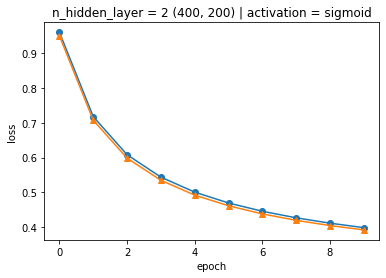

In [16]:
y_pred = dnn.predict(X_test)
print("accuracy score:", accuracy_score(y_test, y_pred))

plt.plot(dnn.train_loss, marker="o", label="train_loss")
plt.plot(dnn.val_loss, marker="^", label="val_loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("n_hidden_layer = 2 (400, 200) | activation = sigmoid")
plt.show()

In [17]:
dnn_5 = ScratchDeepNeuralNetrowkClassifier([500, 300, 150, 100, 50], lr=1e-3, activation="sigmoid", optimizer="adagrad")
dnn_5.fit(X_train, y_train, X_val, y_val, epoch=10, batch_size=20)

Train loss of epoch 0: 1.8386158890113344
Train loss of epoch 1: 1.6184735115809215
Train loss of epoch 2: 1.481516637837168
Train loss of epoch 3: 1.3718197437502446
Train loss of epoch 4: 1.2786065799999609
Train loss of epoch 5: 1.1989894853529564
Train loss of epoch 6: 1.131057840066452
Train loss of epoch 7: 1.0728424421877603
Train loss of epoch 8: 1.0224983768984077
Train loss of epoch 9: 0.9784616703885224


accuracy score: 0.8108


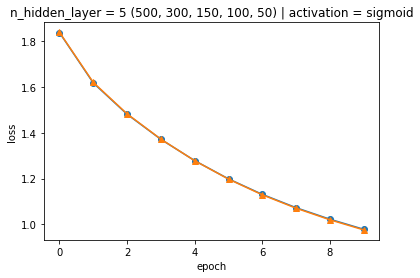

In [18]:
print("accuracy score:", accuracy_score(y_test, dnn_5.predict(X_test)))

plt.plot(dnn_5.train_loss, marker="o", label="train_loss")
plt.plot(dnn_5.val_loss, marker="^", label="val_loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("n_hidden_layer = 5 (500, 300, 150, 100, 50) | activation = sigmoid")
plt.show()

In [19]:
dnn_ReLU = ScratchDeepNeuralNetrowkClassifier([400, 200], lr=1e-3, activation="ReLU", optimizer="adagrad")
dnn_ReLU.fit(X_train, y_train, X_val, y_val, epoch=10, batch_size=20)

Train loss of epoch 0: 0.2774113166898513
Train loss of epoch 1: 0.2375631273255876
Train loss of epoch 2: 0.2158769557484801
Train loss of epoch 3: 0.20091059232135436
Train loss of epoch 4: 0.18952379831280208
Train loss of epoch 5: 0.1804029338223447
Train loss of epoch 6: 0.1727937884145334
Train loss of epoch 7: 0.1662534410698058
Train loss of epoch 8: 0.16053135160177015
Train loss of epoch 9: 0.15544829189776865


accuracy score: 0.9529


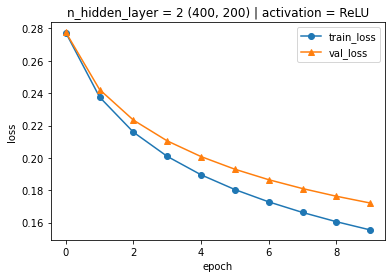

In [20]:
print("accuracy score:", accuracy_score(y_test, dnn_ReLU.predict(X_test)))

plt.plot(dnn_ReLU.train_loss, marker="o", label="train_loss")
plt.plot(dnn_ReLU.val_loss, marker="^", label="val_loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("n_hidden_layer = 2 (400, 200) | activation = ReLU")
plt.legend()
plt.show()

In [29]:
dnn_large = ScratchDeepNeuralNetrowkClassifier([600, 300], lr=1e-3, activation="ReLU", optimizer="adagrad")
dnn_large.fit(X_train, y_train, X_val, y_val, epoch=10, batch_size=20)

Train loss of epoch 0: 0.23660128625261528
Train loss of epoch 1: 0.19996662754003475
Train loss of epoch 2: 0.1799498282131801
Train loss of epoch 3: 0.1661554928588723
Train loss of epoch 4: 0.1557097361070078
Train loss of epoch 5: 0.147316191588935
Train loss of epoch 6: 0.14024193631875553
Train loss of epoch 7: 0.13410870452875995
Train loss of epoch 8: 0.12876449493514613
Train loss of epoch 9: 0.12404344266694306


accuracy score: 0.9587


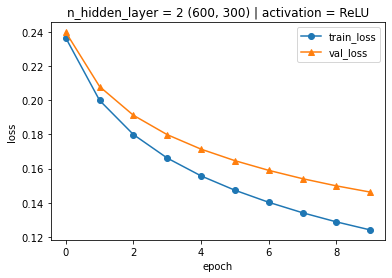

In [30]:
print("accuracy score:", accuracy_score(y_test, dnn_large.predict(X_test)))

plt.plot(dnn_large.train_loss, marker="o", label="train_loss")
plt.plot(dnn_large.val_loss, marker="^", label="val_loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("n_hidden_layer = 2 (600, 300) | activation = ReLU")
plt.legend()
plt.show()

In [31]:
dnn_3 = ScratchDeepNeuralNetrowkClassifier([512, 256, 128], lr=1e-3, activation="ReLU", optimizer="adagrad")
dnn_3.fit(X_train, y_train, X_val, y_val, epoch=10, batch_size=20)

Train loss of epoch 0: 0.2255981895351473
Train loss of epoch 1: 0.18854402748526886
Train loss of epoch 2: 0.1684087975071021
Train loss of epoch 3: 0.15469565497690205
Train loss of epoch 4: 0.1443624850339777
Train loss of epoch 5: 0.13602726496057582
Train loss of epoch 6: 0.129124087469942
Train loss of epoch 7: 0.12322247627850788
Train loss of epoch 8: 0.11805395933213295
Train loss of epoch 9: 0.11349566663951864


accuracy score: 0.962


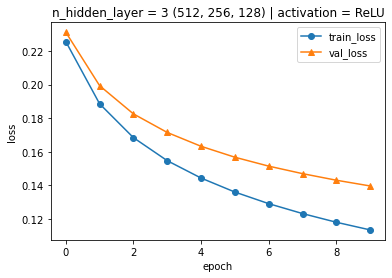

In [33]:
print("accuracy score:", accuracy_score(y_test, dnn_3.predict(X_test)))

plt.plot(dnn_3.train_loss, marker="o", label="train_loss")
plt.plot(dnn_3.val_loss, marker="^", label="val_loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("n_hidden_layer = 3 (512, 256, 128) | activation = ReLU")
plt.legend()
plt.show()

### まとめ

1. ニューロン数を大きくしたとき
2. 隠れ層の数を増やしたとき
3. 活性化関数をSigmoid ⇒ ReLUに変えたとき

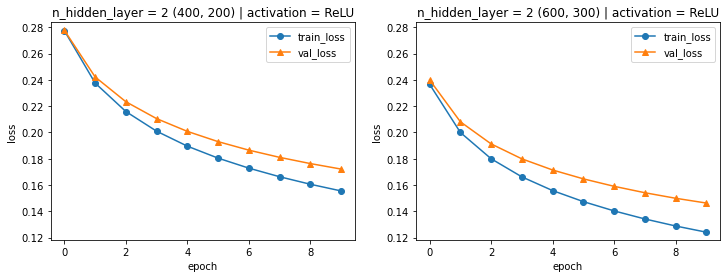

In [52]:
fig, axes = plt.subplots(1,2, figsize=(12,4))

axes[0].plot(dnn_ReLU.train_loss, marker="o", label="train_loss")
axes[0].plot(dnn_ReLU.val_loss, marker="^", label="val_loss")
axes[0].set_xlabel("epoch")
axes[0].set_ylabel("loss")
axes[0].set_title("n_hidden_layer = 2 (400, 200) | activation = ReLU")
axes[0].legend()


axes[1].plot(dnn_large.train_loss, marker="o", label="train_loss")
axes[1].plot(dnn_large.val_loss, marker="^", label="val_loss")
axes[1].set_xlabel("epoch")
axes[1].set_ylabel("loss")
axes[1].set_title("n_hidden_layer = 2 (600, 300) | activation = ReLU")
axes[1].legend()

y_min0, y_max0 = axes[0].get_ylim()
y_min1, y_max1 = axes[1].get_ylim()

y_min = min(y_min0, y_min1)
y_max = max(y_max0, y_max1)

axes[0].set_ylim(y_min, y_max)
axes[1].set_ylim(y_min, y_max)

plt.show()

ニューロンの数を大きくするとより複雑な問題に適合できる

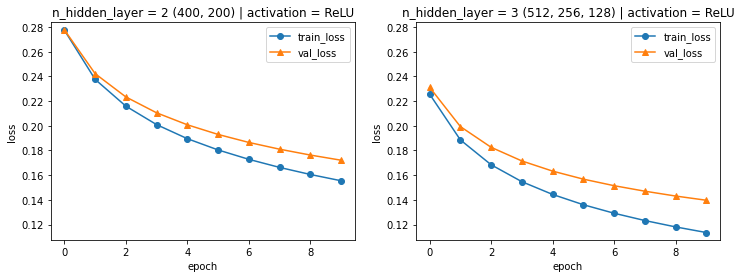

In [54]:
fig, axes = plt.subplots(1,2, figsize=(12,4))

axes[0].plot(dnn_ReLU.train_loss, marker="o", label="train_loss")
axes[0].plot(dnn_ReLU.val_loss, marker="^", label="val_loss")
axes[0].set_xlabel("epoch")
axes[0].set_ylabel("loss")
axes[0].set_title("n_hidden_layer = 2 (400, 200) | activation = ReLU")
axes[0].legend()


axes[1].plot(dnn_3.train_loss, marker="o", label="train_loss")
axes[1].plot(dnn_3.val_loss, marker="^", label="val_loss")
axes[1].set_xlabel("epoch")
axes[1].set_ylabel("loss")
axes[1].set_title("n_hidden_layer = 3 (512, 256, 128) | activation = ReLU")
axes[1].legend()

y_min0, y_max0 = axes[0].get_ylim()
y_min1, y_max1 = axes[1].get_ylim()

y_min = min(y_min0, y_min1)
y_max = max(y_max0, y_max1)

axes[0].set_ylim(y_min, y_max)
axes[1].set_ylim(y_min, y_max)

plt.show()

層の数を増やすとより精度があがる

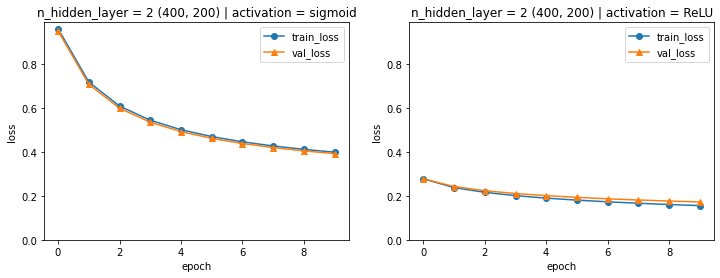

In [46]:
fig, axes = plt.subplots(1,2, figsize=(12,4))

axes[0].plot(dnn.train_loss, marker="o", label="train_loss")
axes[0].plot(dnn.val_loss, marker="^", label="val_loss")
axes[0].set_xlabel("epoch")
axes[0].set_ylabel("loss")
axes[0].set_title("n_hidden_layer = 2 (400, 200) | activation = sigmoid")
y_min, y_max = axes[0].get_ylim()
axes[0].set_ylim(0, y_max)
axes[0].legend()

axes[1].plot(dnn_ReLU.train_loss, marker="o", label="train_loss")
axes[1].plot(dnn_ReLU.val_loss, marker="^", label="val_loss")
axes[1].set_xlabel("epoch")
axes[1].set_ylabel("loss")
axes[1].set_title("n_hidden_layer = 2 (400, 200) | activation = ReLU")
axes[1].set_ylim(0, y_max)
axes[1].legend()
plt.show()

活性化関数の種類を変えることで精度に大きな差がある

# テスト

In [ ]:
class TestInitializer1:
    def W(self, n_nodes1, n_nodes2):
        W = np.array([[5, 3, 1], [4, 2, 0]], dtype=np.float)
        return W
    
    def B(self, n_nodes2):
        B = np.array([-20, -10, -12], dtype=np.float)
        return B

    
class TestInitializer2:
    def W(self, n_nodes1, n_nodes2):
        W = np.array([[-4, 3], [-6, 1], [-8, 5]], dtype=np.float)
        return W
    
    def B(self, n_nodes2):
        B = np.array([10, 15], dtype=np.float)
        return B

class TestInitializer3:
    def W(self, n_nodes1, n_nodes2):
        W = np.array([[-4, 3, -3, 5], [-6, 1, -2, 2]], dtype=np.float)
        return W
    
    def B(self, n_nodes2):
        B = np.array([10, 15, -10, -5], dtype=np.float)
        return B


In [ ]:
XX = np.array([[1,2],[3,4],[5,6],[7,8]], dtype=np.float)
yy = np.array([0,1,2,3])

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
yy_one_hot = enc.fit_transform(yy[:, np.newaxis])

n_nodes1 = 3
n_nodes2 = 2
n_output = yy_one_hot.shape[1]
n_features = XX.shape[1]
lr = 0.01
sigma = 0.1

optimizer = SGD(lr)
FC1 = FC(n_features, n_nodes1, TestInitializer1(), optimizer)
activation1 = Sigmoid()
FC2 = FC(n_nodes1, n_nodes2, TestInitializer2(), optimizer)
activation2 = Sigmoid()
FC3 = FC(n_nodes2, n_output, TestInitializer3(), optimizer)
activation3 = Softmax()

A1 = FC1.forward(XX)
Z1 = activation1.forward(A1)
A2 = FC2.forward(Z1)
Z2 = activation2.forward(A2)
A3 = FC3.forward(Z2)
Z3 = activation3.forward(A3)

dA3 = activation3.backward(Z3, yy_one_hot) 
dZ2 = FC3.backward(dA3)
dA2 = activation2.backward(dZ2)
dZ1 = FC2.backward(dA2)
dA1 = activation1.backward(dZ1)
dZ0 = FC1.backward(dA1) # dZ0は使用しない

